# CS 168 Spring Assignment [TODO]

SUNet ID(s): 05794739

Name(s): Luis A. Perez

Collaborators: None

By turning in this assignment, I agree by the Stanford honor code and declare
that all of this is my own work.


# Imports

In [149]:
import collections
import matplotlib.pyplot as plt
import hashlib
import enum
import numpy as np
import pandas as pd
import seaborn as sns
import random

from typing import Callable, List, Iterator, Text, Tuple

# Make figure larger
plt.rcParams['figure.figsize'] = [10, 5]

## Part 1

### Part 1a : Defining each strategy.

**Strategy 1** Select one of the $N$ bins uniformly at random, and place the current ball in it.

In [63]:
def strategy1(N: int) -> int:
    """Select one of N bins uniformly and place one of the N balls in it.
    
    Args:
        N: The number of bins and number of balls.
        
    Returns:
        The number of balls in the most populated bin.
    """
    binIdxSamples = np.random.randint(low=0, high=N, size=N)
    bins = collections.Counter(binIdxSamples)
    return max(bins.items(), key=lambda x: x[1])[1]

**Strategy 2**
Select two of the $N$ bins uniformly at random (either with or without replacement), and look at how many balls are already in each.  If one bin has strictly fewer balls than the other, place the current ball in that bin.  If both bins have the same number of balls, pick one of the two at random and place the current ball in it.

In [64]:
def strategy2(N: int) -> int:
    """Select two bins at random and place ball into bin with fewer. Break ties at random.
    
    Args:
        N: The number of bins and number of balls.
        
    Returns:
        The number of balls in the most populated bin.
    """
    firstIdx = np.random.randint(low=0, high=N, size=N)
    secondIdx = np.random.randint(low=0, high=N, size=N)
    coinFlips = np.random.randint(low=0, high=2, size=N)
    bins = collections.Counter()
    for flip, (i,j) in enumerate(zip(firstIdx, secondIdx)):
        if bins[i] < bins[j]:
            bins[i] += 1
        elif bins[j] < bins[i]:
            bins[j] += 1
        else:
            bins[i if coinFlips[flip] else j] += 1
    return max(bins.items(), key=lambda x: x[1])[1]

**Strategy 3**: Same as Strategy 2 except with 3 bins at random.

In [65]:
def strategy3(N: int) -> int:
    """Select three bins at random and place ball into bin with fewer. Break ties at random.
    
    Args:
        N: The number of bins and number of balls.
        
    Returns:
        The number of balls in the most populated bin.
    """
    firstIdx = np.random.randint(low=0, high=N, size=N)
    secondIdx = np.random.randint(low=0, high=N, size=N)
    thirdIdx = np.random.randint(low=0, high=N, size=N)
    doubleTieFlip = np.random.randint(low=0, high=2, size=N)
    tripleTieFlip = np.random.randint(low=0, high=3, size=N)
    bins = collections.Counter()
    for flip, (i,j,k) in enumerate(zip(firstIdx, secondIdx, thirdIdx)):
        sortedOutcomes = sorted([(bins[i],i), (bins[j], j), (bins[k], k)])
        # Triple tie.
        if bins[i] == bins[j] and bins[j] == bins[k]:
            flipOutcome = tripleTieFlip[flip]
            if flipOutcome == 0:
                bins[i] += 1
            elif flipOutcome == 1:
                bins[j] += 1
            elif flipOutcome == 2:
                bins[j] += 1
            else:
                assert False, "%s is not a valid triple flip outcome" % flipOutcome
        # Min double tie.
        elif sortedOutcomes[0][0] == sortedOutcomes[1][0]:
            outcome = sortedOutcomes[0 if doubleTieFlip[flip] else 1]
            bins[outcome[1]] += 1
        # No tie.
        else:
            outcome = sortedOutcomes[0]
            bins[outcome[1]] += 1
    return max(bins.items(), key=lambda x: x[1])[1]

**Strategy 4**: Select two bins as follows:  the first bin is selected uniformly from the first $\frac{N}{2}$ bins, and the second uniformly from the last $\frac{N}{2}$ bins.  (You can assume that $N$ is even.)  If one bin has strictly fewer balls than the other, place the current ball in that bin.  If both bins have the same number of balls, place the current ball (deterministically) in the first of the two bins.

In [66]:
def strategy4(N: int) -> int:
    """Select bin from first half and second half. Place ball into bin with fewer balls, favoring first half.
    
    Args:
        N: The number of bins and number of balls.
        
    Returns:
        The number of balls in the most populated bin.
    """
    assert N % 2 == 0, "We assume for Strategy 4 that N is even!"
    firstIdx = np.random.randint(low=0, high=N // 2, size=N)
    secondIdx = np.random.randint(low=N // 2 + 1, high=N, size=N)
    bins = collections.Counter()
    for (first, second) in zip(firstIdx, secondIdx):
        if bins[first] <= bins[second]:
            bins[first] += 1
        else:
            bins[second] += 1
    return max(bins.items(), key=lambda x: x[1])[1]

### Part 1b: Simulation

In [116]:
def simulate(strategy_fn: Callable[[int], int], nTrials: int, title: Text) -> None:
    """Simulates the given stragy nTrials and plots the histogram.
    
    Args:
        strategy_fn: The callable defining the strategy.
        nTrials: The number of trials to run.
        title: The plot title for the generated histogram.
    """
    N = 200000
    simulation_results = [strategy_fn(N) for _ in range(nTrials)]
    counts = collections.Counter(simulation_results)
    data = pd.DataFrame(zip(counts.keys(), counts.values()),
                        columns=['value', 'count'])
    sns.barplot(data=data, x='value', y='count')
    plt.xlabel('X')
    plt.ylabel('Count')
    plt.title("Histogram of %s" % title)
    plt.savefig('figures/%s.png' % title, dpi=1200)
    plt.show()

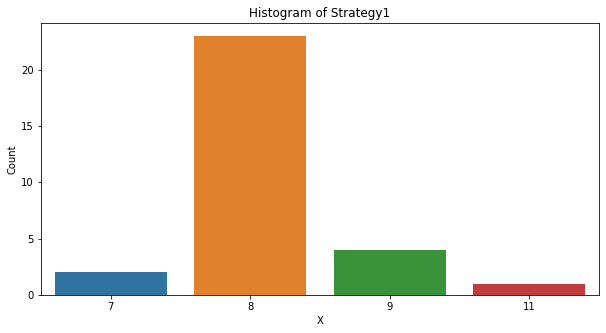

In [121]:
simulate(strategy1, nTrials=30, title="Strategy1")

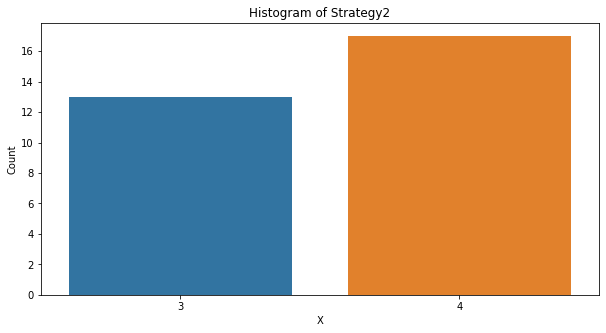

In [122]:
simulate(strategy2, nTrials=30, title="Strategy2")

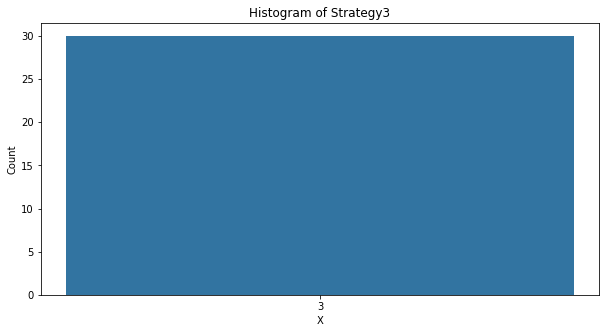

In [123]:
simulate(strategy3, nTrials=30, title="Strategy3")

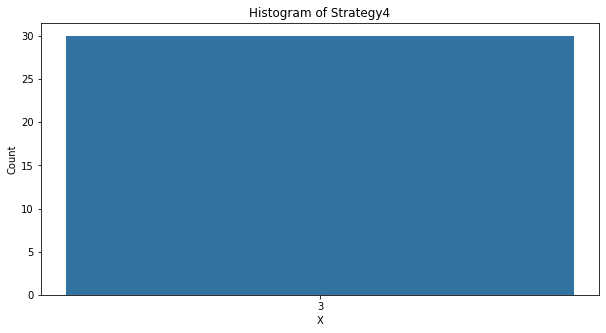

In [126]:
simulate(strategy4, nTrials=30, title="Strategy4")

## Part 2

In [198]:
class CountMinSketch:
    """Implementation of the CountMinSketch datastructure."""
    def __init__(self, trial: int, b=256, l=4, isConservative: bool=False) -> None:
        self._id = trial
        # Number of buckets.
        self.b = b
        # Number of hash functions
        self.l = l
        self.isConservative = isConservative
        self._table = [[0] * self.b for _ in range(self.l)]
        
    def _hash(self, x: int) -> List[int]:
        """Hashes x to the correspondg self.l hash functions."""
        inputString = (str(x) + str(self._id - 1)).encode('utf-8')
        inputHash = hashlib.md5(inputString).hexdigest()
        return [int(inputHash[2*i:2*(i+1)], 16) % self.b
                for i in range(self.l)]
        
    def Increment(self, x: int) -> None:
        """Increments the count of x."""
        hashes = self._hash(x)
        if self.isConservative:
            currentCounts = [self._table[i][h]
                             for i, h in enumerate(hashes)]
            minCount = min(currentCounts)
        else:
            minCount = None
        for i, h in enumerate(hashes):
            if minCount is None or self._table[i][h] == minCount:
                self._table[i][h] += 1      
        
    def Count(self, x: int) -> int:
        return min([self._table[i][h]
                    for i, h in enumerate(self._hash(x))])

In [199]:
@enum.unique
class StreamType(enum.Enum):
    FORWARD = 1
    REVERSE = 2
    RANDOM = 3

In [200]:
def generate_stream(sType: StreamType) -> Iterator[int]:
    """Iterator for the stream of the given type."""
    if sType == StreamType.FORWARD:
        i = 0
        while i < 9:
            for el in range(i*1000 + 1, (i+1)*1000 + 1):
                for _ in range(i + 1):
                    yield el
            i += 1
        for el in range(9001, 9051):
            for _ in range((el - 9000)**2):
                yield el
    elif sType == StreamType.REVERSE:
        # Just materialize and reverse it...
        for el in reversed(list(generate_stream(StreamType.FORWARD))):
            yield el
    elif sType == StreamType.RANDOM:
        materialized = list(generate_stream(StreamType.FORWARD))
        random.shuffle(materialized)
        for el in materialized:
            yield el
    else:
        assert False

In [201]:
def simulate_stream(sketch: CountMinSketch, sType: StreamType) -> Tuple[int, int]:
    """Simulates the specified stream.
    
    Returns:
        Estimate of frequency of element 9050.
        Estimate for the number of heavy hitters.
    """
    def is_heavy_hitter(el: int) -> bool:
        return sketch.Count(el) >= 841
    
    for element in generate_stream(sType):
        sketch.Increment(element)
        
    estimateOf9050 = sketch.Count(9050)
    heavyHitters = [el for el in range(1, 9051)
                     if is_heavy_hitter(el)]
    return estimateOf9050, len(heavyHitters)

In [202]:
def simulate_trials_for_stream(
    sType: StreamType, isConservative: bool, trials: int=10) -> Tuple[float, float]:
    """Simulates multiple trials for the stream type.
    
    Returns:
        Average estimate of frequency of element 9050.
        Average estimate for the number of heavy hitters.
    """
    results = [simulate_stream(
        CountMinSketch(trial, isConservative=isConservative), sType) 
     for trial in range(1, trials +1)]
    estimatesOf9050, numHeavies = zip(*results)
    return np.mean(estimatesOf9050), np.mean(numHeavies)

In [207]:
def problem2c():
    for sType in StreamType:
        meanFreq9050, meanNumHeavies = simulate_trials_for_stream(
            sType, isConservative=False)
        print("For %s Stream, the mean estimate for the frequency "
             "of 9050 is %s, while the mean estimate of the number of "
             "heavy hitters is %s." % (sType.name, meanFreq9050, meanNumHeavies))

In [208]:
def problem2f():
    for sType in StreamType:
        meanFreq9050, meanNumHeavies = simulate_trials_for_stream(
            sType, isConservative=True)
        print("[Conservative] For %s Stream, the mean estimate for the frequency "
             "of 9050 is %s, while the mean estimate of the number of "
             "heavy hitters is %s." % (sType.name, meanFreq9050, meanNumHeavies))

In [209]:
problem2c()

For FORWARD Stream, the mean estimate for the frequency of 9050 is 2645.7, while the mean estimate of the number of heavy hitters is 24.6.
For REVERSE Stream, the mean estimate for the frequency of 9050 is 2645.7, while the mean estimate of the number of heavy hitters is 24.6.
For RANDOM Stream, the mean estimate for the frequency of 9050 is 2645.7, while the mean estimate of the number of heavy hitters is 24.6.


In [210]:
problem2f()

[Conservative] For FORWARD Stream, the mean estimate for the frequency of 9050 is 2577.2, while the mean estimate of the number of heavy hitters is 23.4.
[Conservative] For REVERSE Stream, the mean estimate for the frequency of 9050 is 2500.0, while the mean estimate of the number of heavy hitters is 22.2.
[Conservative] For RANDOM Stream, the mean estimate for the frequency of 9050 is 2500.0, while the mean estimate of the number of heavy hitters is 22.2.
